# Examples to analyze area lipid and thickness from the NMRlipids databank

This notebook exemplifies how to:
1. Plot area per lipid from binary mixtures as function of lipid composition
2. Plot correlation between membrane thickness and area
3. Plot correlation between form factor minima and area per lipid
4. Plot correlation between form factor minima and membrane thickness

# Initialize NMRlipids databank

In [2]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import MDAnalysis
import urllib.request
import yaml

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Databank/Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

def CalcAreaPerMolecule(system):
    APLpath = system['path'] + 'apl.json'
    try:
        f = open(APLpath)
        APLdata = json.load(f)
        sumAPL = 0
        sumIND = 0
        for i,j in APLdata.items():
            sumAPL += j
            sumIND += 1
        APL = sumAPL/sumIND
        return(APL)
    except:
        print('apl.json not found from' + system['path'])
        
def GetThickness(system):
    ThicknessPath = system['path'] + 'thickness.json'
    try:
        f = open(ThicknessPath)
        thickness = json.load(f)
        return(thickness)
    except:
        pass
        #print('thickness.json not found from' + system['path'])
    
    
def GetFormFactorMin(system):
    FormFactorPath = system['path'] + 'FormFactor.json'
    #try:
    f = open(FormFactorPath)
    FormFactor = json.load(f)
    min = 1000
    iprev = FormFactor[0][1]
    iprevD = 0
    minX = []
    for i in FormFactor:
        iD = i[1]-iprev
        if iD > 0 and iprevD < 0 and i[0] > 0.1:
            minX.append(i[0])
        iprevD = i[1]-iprev
        iprev = i[1]
        
    return(minX)

# Create area per lipid data of mixtures containing MATRIX or ADDITIVE lipids, or both

In [5]:
## You can change these to define the MATRIX and ADDITIVE lipids
MATRIX = 'POPC'
ADDITIVE = 'CHOL'



ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
!mkdir {ResultDir}
!rm {ResultDir}/*

apl_DICT = {}
for system in systems:
    
    try:
        NADDITIVE = np.sum(system['COMPOSITION'][ADDITIVE]['COUNT'])
    except:
        NADDITIVE = 0    
    
    try:
        NMATRIX = np.sum(system['COMPOSITION'][MATRIX]['COUNT'])
    except:
        NMATRIX = 0
    
    NLIPIDS = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NLIPIDS += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    if (NMATRIX + NADDITIVE) != NLIPIDS:
        #print('skipped')
        continue
    
    
    APL = CalcAreaPerMolecule(system)
    if not APL:
        continue
    
    #plt.plot(NADDITIVE / NLIPIDS, APL,'.')
    
    try:
        CaConcentration = system['COMPOSITION']['CAL']['COUNT'] * 55.5 / system['COMPOSITION']['SOL']['COUNT']
    except:
        CaConcentration = 0
    lipidsRATIO = 100*NADDITIVE / NLIPIDS
    forcefield = system.get('FF')
    temperature = system.get('TEMPERATURE')
    DOI = system.get('DOI')
    apl_DICT[lipidsRATIO,CaConcentration,forcefield,temperature,DOI] = APL
   
    OutFileName = ResultDir + 'T' + str(temperature) + 'K'

    try:
        NSOD = np.sum(system['COMPOSITION']['SOD']['COUNT'])
    except:
        NSOD = 0    
        
    try:
        NCLA = np.sum(system['COMPOSITION']['CLA']['COUNT'])
    except:
        NCLA = 0    
    
    if NCLA > 0 and not 'DHMDMAB' in ADDITIVE:
        #print('skipped')
        continue
        
    if ('POPG' in ADDITIVE or 'POPS' in ADDITIVE) and NADDITIVE != NSOD:
        #print('skipped')
        continue
    
    try:
        OutFileName = OutFileName + '_' + system['FF'] +'.dat'
    except:
        continue
    #print(OutFileName)
    
    outfile=open(OutFileName,'a')
    outfile.write(str(round(lipidsRATIO,3)) + " " + str(APL) + " " + str(system['DOI']))
    outfile.write('\n')
    outfile.close()
    !sort -n -k 1 {OutFileName} -o {OutFileName}

mkdir: cannot create directory ‘./results/CHOL_in_POPC/’: File exists
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sort -n -k 1 ./results/CHOL_in_POPC/T303.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat -o ./results/CHOL_in_POPC/T303.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sort -n -k 1 ./results/CHOL_in_POPC/T310.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat -o ./results/CHOL_in_POPC/T310.0K_CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions).dat'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sort -n -k 1 ./results/CHOL_in_POPC/T310.0K_CHARMM36 (center of mass removed independently for upper leaflet, lowe

# Plot area per lipid data of MATRIX and ADDITIVE mixtures 

Text(0, 0.5, 'Area per molecule (Å)^2')

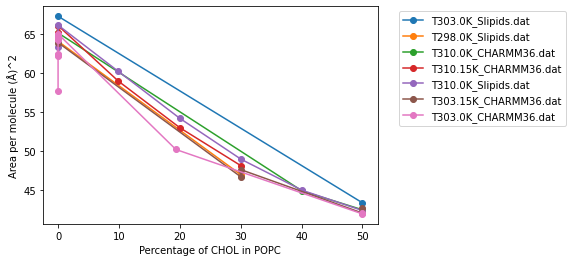

In [6]:
for subdir, dirs, files in os.walk(ResultDir):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".dat"):
            with open(filepath) as APLfile:
                lines = APLfile.readlines()#[1:]
                x = [float(line.split()[0]) for line in lines]
                y = [float(line.split()[1]) for line in lines]
                #print(filepath,x,y)
                if len(set(x)) > 1:
                    plt.plot(x,y,label = filename,marker='o')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX)
plt.ylabel('Area per molecule (Å)^2')
#plt.savefig('../Figs/aplTST.png', bbox_inches='tight')

# Plot correlation between membrane thickness and area per molecule

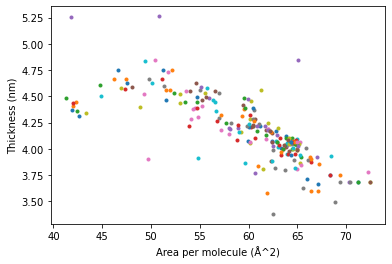

In [3]:
APL = []
Thickness = []
for system in systems:
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if APLvalue and ThicknessValue:
        plt.plot(APLvalue,ThicknessValue,'.')
    plt.xlabel('Area per molecule (Å^2)')
    plt.ylabel('Thickness (nm)')

# Correlation between area per lipid and the first three minima of form factors

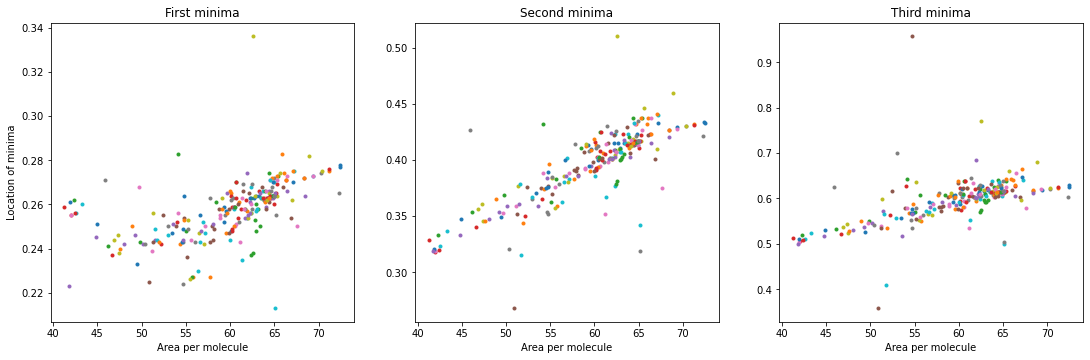

In [42]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig1.set_size_inches(18.5, 5.5)
ax1.set_title("First minima")
ax2.set_title("Second minima")
ax3.set_title("Third minima")
ax1.set_ylabel("Location of minima")
ax1.set_xlabel("Area per molecule")
ax2.set_xlabel("Area per molecule")
ax3.set_xlabel("Area per molecule")

#ax1.set_ylim([0, 1])
#ax2.set_ylim([0, 1])
#ax3.set_ylim([0, 1])

for system in systems:
    try:
        FFmins = GetFormFactorMin(system)
    except:
        pass
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    ax1.plot(APLvalue,FFmins[0],'.')
    ax2.plot(APLvalue,FFmins[1],'.')
    ax3.plot(APLvalue,FFmins[2],'.')
    #plt.plot(APLvalue,FFmins[i],'.')

# Correlation between thickness and the first three minima of form factors

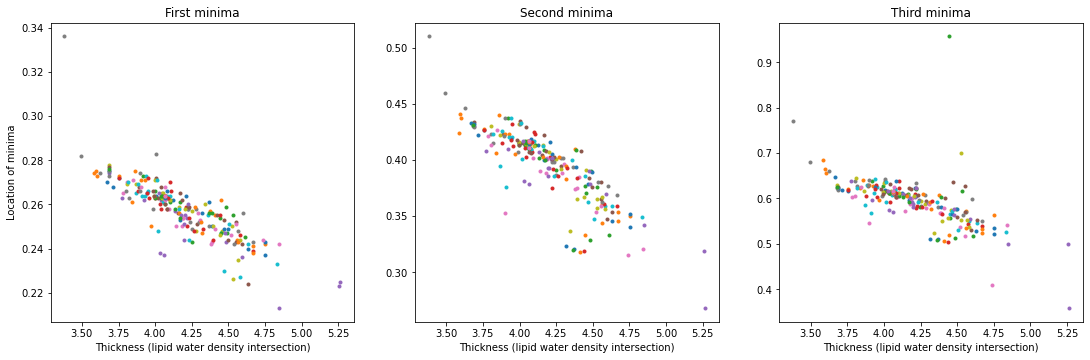

In [41]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig1.set_size_inches(18.5, 5.5)
ax1.set_title("First minima")
ax2.set_title("Second minima")
ax3.set_title("Third minima")
ax1.set_ylabel("Location of minima")
ax1.set_xlabel("Thickness (lipid water density intersection)")
ax2.set_xlabel("Thickness (lipid water density intersection)")
ax3.set_xlabel("Thickness (lipid water density intersection)")


#ax1.set_ylim([0, 1])
#ax2.set_ylim([0, 1])
#ax3.set_ylim([0, 1])

for system in systems:
    #print(system['path'])
    try:
        FFmins = GetFormFactorMin(system)
    except:
        pass
        #print('Failed')
    #APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if ThicknessValue:
        ax1.plot(ThicknessValue,FFmins[0],'.')
        ax2.plot(ThicknessValue,FFmins[1],'.')
        ax3.plot(ThicknessValue,FFmins[2],'.')
        #plt.plot(ThicknessValue,FFmins[0],'.')
    